In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')


In [1]:
import os
import pandas as pd
import numpy as np
import joblib

import glob
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from keras.models import load_model, save_model

from keras.metrics import mean_squared_error as keras_mse
from keras.layers import Flatten, Dense, Conv2D, GlobalMaxPooling2D, MaxPooling2D, Input, Dropout, BatchNormalization, GlobalAveragePooling2D, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.mobilenet_v3 import MobileNetV3Large
from keras.applications.mobilenet_v3 import preprocess_input as preprocess_input_mobilenet


if str(os.getcwdb()[-3:]).split("'")[1] != 'src':
    for _ in range(2):
        os.chdir(os.path.dirname(os.getcwdb()))

from utils.classes import *
from utils.functions import *

In [6]:
processed_images_path = r'data\processed\images'
df_images_data_original = pd.read_csv(r'data\processed\images_data_processed.csv')

# df_images_data_original = pd.read_csv('/content/gdrive/My Drive/images_data_processed.csv')
# processed_images_path = r'/content/gdrive/My Drive/images'

df_images_data_original.head()


,Id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),length (millimeters),width (millimeters),depth (millimeters),price
0,1638147,0.55,4.0,5.0,1.0,62.553191,5.05,4.35,2.94,1378.65
1,1612606,0.51,4.0,2.0,3.0,64.900662,4.71,4.35,2.94,1380.19
2,1638140,0.50,4.0,2.0,3.0,62.813522,4.91,4.26,2.88,1380.61
3,1536093,0.53,4.0,6.0,2.0,65.720524,4.70,4.46,3.01,1383.13
4,1643527,0.52,4.0,1.0,6.0,65.141612,4.76,4.42,2.99,1384.24


# Prueba 1 (fracaso)

- Para esta primera prueba, se intenta obtener todas las características de los diamantes con un modelo VGG16

- Se elige este modelo por las siguientes razones:

1) Es popular y se ha utilizado con éxito en investigación
2) Es relativamente fácil adaptarlo para problemas de regresión
3) Tiene un buen rendimiento
4) Trabaja con RGB, y el color de los diamantes es importante
5) Utiliza un tamaño de 224x224, y se ha visto que a partir de 150 componentes se obtiene toda la información necesaria
6) Otros como ResNet, Inception y EfficientNet son más modernos y tienen el potencial de dar mejores resultados, pero el coste computacional podría elevarse, lo que quizá no valdría la pena para un "dataset" tan pequeño

- El modelo es lento y no da resultados demasiado buenos por la siguientes razones:

1) Las redes neuronales no son muy eficaces para regresión, razón por la cual se encuentran pocos "papers" científicos que lo intenten. La situación se agrava porque se pretende predecir 7 "targets"

2) De esas "targets", hay varias que en realidad son de clasificación, como el corte y el color del diamante

3) La tarea de discernir el peso o las dimensiones de un diamante sin un punto de referencia es muy complicada

## Tamaño de las imágenes

- Se modifican los píxeles de cada imagen, de 300 a 224, para que puedan encajar en el modelo

In [ ]:
for image_path in glob.glob(processed_images_path+'/*.jpg'):
    with Image.open(image_path) as image:
        image = image.resize((224, 224))
        image.save(image_path)


In [ ]:
for image in glob.glob(processed_images_path+'/*.jpg'):
    image_matrix = cv2.imread(image)
    break

image_matrix.shape


## "Split"

- Se separa el "dataframe" en "train" y "test"

In [ ]:
df_images_data = df_images_data_original.copy()

df_images_data = df_images_data.drop(columns='price')

df_images_data['Id'] = df_images_data['Id'].apply(lambda x: x + '.jpg')

df_images_data.head()


,Id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),length (millimeters),width (millimeters),depth (millimeters)
0,1638147.jpg,0.55,4.0,5.0,1.0,62.553191,5.05,4.35,2.94
1,1612606.jpg,0.51,4.0,2.0,3.0,64.900662,4.71,4.35,2.94
2,1638140.jpg,0.50,4.0,2.0,3.0,62.813522,4.91,4.26,2.88
3,1536093.jpg,0.53,4.0,6.0,2.0,65.720524,4.70,4.46,3.01
4,1643527.jpg,0.52,4.0,1.0,6.0,65.141612,4.76,4.42,2.99


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_images_data['Id'], df_images_data.drop(columns='Id'), train_size=0.8, random_state=42)

df_train = pd.concat((X_train, y_train), axis=1)
df_test = pd.concat((X_test, y_test), axis=1)

df_train.head()


,Id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),length (millimeters),width (millimeters),depth (millimeters)
1084,1782710.jpg,0.31,4.0,6.0,6.0,53.199498,4.68,3.29,2.12
2564,211174-39.jpg,1.00,4.0,1.0,5.0,49.358060,8.52,5.50,3.46
2857,1634758.jpg,0.70,4.0,-1.0,4.0,72.427984,4.90,4.82,3.52
4325,1659667.jpg,0.50,1.0,5.0,3.0,62.851406,4.94,5.02,3.13
1482,1785268.jpg,0.30,4.0,6.0,3.0,63.060990,3.98,4.71,2.74


## "Data augmentation"

- Se crea una variable para generar imágenes en diferentes posiciones para que el modelo disponga del mismo diamante colocado de modos distintos


In [ ]:
# Se establecen las variables para crear nuevos diamantes y para seleccionar el tamaño de imagen correcto
data_augmentation = ImageDataGenerator(rotation_range=20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        preprocessing_function=preprocess_input,
                                        validation_split=0.1
                                        )


In [ ]:
# Se crean tres "generators" con los datos aumentados (entrenamiento, validación y "test")
train_generator = data_augmentation.flow_from_dataframe(dataframe=df_train,
                                                        directory=processed_images_path,
                                                        target_size=(224, 224),
                                                        class_mode='raw',
                                                        shuffle=False,
                                                        x_col='Id',
                                                        y_col=list(df_images_data.columns[1:]),
                                                        seed=42,
                                                        subset='training'
                                                        )

validation_generator = data_augmentation.flow_from_dataframe(dataframe=df_train,
                                                                directory=processed_images_path,
                                                                target_size=(224, 224),
                                                                class_mode='raw',
                                                                shuffle=False,
                                                                x_col='Id',
                                                                y_col=list(df_images_data.columns[1:]),
                                                                seed=42,
                                                                subset='validation'
                                                                )

test_generator = data_augmentation.flow_from_dataframe(dataframe=df_test,
                                                        directory=processed_images_path,
                                                        target_size=(224, 224),
                                                        class_mode='raw',
                                                        shuffle=False,
                                                        x_col='Id',
                                                        y_col=list(df_images_data.columns[1:]),
                                                        seed=42,
                                                        )


Found 3254 validated image filenames.
Found 361 validated image filenames.
Found 904 validated image filenames.


## Arquitectura

In [ ]:
# Se carga el modelo sin la capa superior
base_model = VGG16(include_top=False, input_shape=((224, 224, 3)))


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Se congelan las capas base para que no se entrenen al tunear parámetros, sino que queden igual
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
# Se crea una nueva capa superior
top_model = Flatten()(base_model.output)
top_model = Dense(1024, activation='relu')(top_model)
top_model = Dense(512, activation='relu')(top_model)
output_layer = Dense(8, activation='linear')(top_model)


In [ ]:
# Se tunea el modelo con la capa nueva
model = Model(inputs=base_model.input, outputs=output_layer)


In [ ]:
# Se compila y se le pone un optimizador
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')


## Entrenamiento

In [ ]:
# Se entrena el modelo con "early stopping"
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_generator,
                    epochs=20,
                    batch_size=64,
                    validation_data=validation_generator,
                    callbacks=[early_stop]
                    )


Epoch 1/20
102/102 [==============================] - 1658s 16s/step - loss: 4.7631 - val_loss: 1.8354
Epoch 2/20
102/102 [==============================] - 1619s 16s/step - loss: 1.6331 - val_loss: 1.5055
Epoch 3/20
102/102 [==============================] - 1621s 16s/step - loss: 1.4628 - val_loss: 1.4908
Epoch 4/20
102/102 [==============================] - 1622s 16s/step - loss: 1.3511 - val_loss: 1.4441
Epoch 5/20
102/102 [==============================] - 1623s 16s/step - loss: 1.3218 - val_loss: 1.2371
Epoch 6/20
102/102 [==============================] - 1628s 16s/step - loss: 1.2581 - val_loss: 1.2024
Epoch 7/20
102/102 [==============================] - 1620s 16s/step - loss: 1.2337 - val_loss: 1.2048
Epoch 8/20
102/102 [==============================] - 1623s 16s/step - loss: 1.2070 - val_loss: 1.1370
Epoch 9/20
102/102 [==============================] - 1610s 16s/step - loss: 1.1842 - val_loss: 1.0816
Epoch 10/20
102/102 [==============================] - 1622s 16s/step - l

In [ ]:
y_pred = model.predict(test_generator)


29/29 [==============================] - 403s 14s/step


## Resultados

In [ ]:
# Se obtienen las métricas
metrics_dict = dict()
for index, col in enumerate(df_images_data.columns[1:]):
    rmse = mean_squared_error([row[index] for row in test_generator.labels], [row[index] for row in y_pred], squared=False)
    mse = mean_squared_error([row[index] for row in test_generator.labels], [row[index] for row in y_pred])
    mae = mean_absolute_error([row[index] for row in test_generator.labels], [row[index] for row in y_pred])
    r2 = r2_score([row[index] for row in test_generator.labels], [row[index] for row in y_pred])
    mape = mean_absolute_percentage_error([row[index] for row in test_generator.labels], [row[index] for row in y_pred])
    metrics_dict[col] = {'mse': mse,
                            'rmse': rmse,
                            'mae': mae,
                            'r2': r2,
                            'mape': mape
                         }

metrics_dict


{'weight (carat)': {'mse': 0.1336372049921532,
  'rmse': 0.36556422827206875,
  'mae': 0.2417054289899173,
  'r2': -0.03505052079897086,
  'mape': 0.4639574649408659},
 'cut quality': {'mse': 1.2739422312412216,
  'rmse': 1.1286904939978992,
  'mae': 0.818438103010433,
  'r2': -0.1435679608231537,
  'mape': 72608940205989.75},
 'color quality': {'mse': 4.147202059491201,
  'rmse': 2.0364680354700395,
  'mae': 1.6430471274544345,
  'r2': 0.5249337891759873,
  'mape': 794924327189803.6},
 'clarity quality': {'mse': 2.2534897969237186,
  'rmse': 1.5011628149283869,
  'mae': 1.139925202503141,
  'r2': 0.009078528522102447,
  'mape': 43805370364375.625},
 'depth (percentage)': {'mse': 20.30939250731928,
  'rmse': 4.5065943357838725,
  'mae': 3.521957158820884,
  'r2': 0.6469763987724068,
  'mape': 0.05941118910892257},
 'length (millimeters)': {'mse': 0.5882077754517148,
  'rmse': 0.7669470486622364,
  'mae': 0.5708067799352967,
  'r2': 0.6074706713139164,
  'mape': 0.10523307766039347},
 '

In [ ]:
# Se visualiza la predicción del peso, que es la más importante, en un "dataframe"
df_weight = pd.DataFrame(data={'original weight': [row[0] for row in test_generator.labels], 'Prediction': [row[0] for row in y_pred]})

df_weight


,original weight,Prediction
0,0.50,0.486493
1,1.61,0.900453
2,0.50,0.682085
3,0.75,0.906518
4,0.50,0.750089
...,...,...
899,0.50,0.571988
900,0.50,0.633700
901,0.31,0.448187
902,0.50,0.534622


# Prueba 2 (éxito parcial, combinado con prueba 3)

- Como predecir tantas variables es muy difícil, se decide ir directamente a por el precio, sin tener que pasar las características a posteriori por el modelo de "machine learning" ya creado. 

- Se utiliza un modelo MobileNetV3Large, que es potente, de una fuente confiable (Google), y que se ha demostrado eficaz para la detección de imágenes

- Como puede tardar todavía más que el anterior, se pone en marcha en Google Collab y se aprovecha la GPU. Las partes del código solo usadas en Collab se encuentran comentadas

- El resultado es bastante flojo, pero menos escandaloso que en la Prueba 1

In [7]:
df_images_data = df_images_data_original.copy()

df_images_data = df_images_data[['Id', 'price']]

df_images_data['Id'] = df_images_data['Id'].apply(lambda x: x + '.jpg')

scaler = StandardScaler()

df_images_data['price'] = scaler.fit_transform(df_images_data[['price']])

df_images_data.head()


,Id,price
0,1638147.jpg,-0.254320
1,1612606.jpg,-0.253912
2,1638140.jpg,-0.253801
3,1536093.jpg,-0.253133
4,1643527.jpg,-0.252839


In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_images_data['Id'], df_images_data.drop(columns='Id'), train_size=0.8, random_state=42)

df_train = pd.concat((X_train, y_train), axis=1)
df_test = pd.concat((X_test, y_test), axis=1)

df_train.head()


,Id,price
1084,1782710.jpg,-0.313508
2564,211174-39.jpg,1.121658
2857,1634758.jpg,-0.108507
4325,1659667.jpg,-0.069858
1482,1785268.jpg,-0.331227


In [9]:
data_augmentation = ImageDataGenerator(rotation_range=20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        preprocessing_function=preprocess_input_mobilenet,
                                        validation_split=0.3
                                        )


In [10]:
train_generator = data_augmentation.flow_from_dataframe(dataframe=df_train,
                                                        directory=processed_images_path,
                                                        target_size=(224, 224),
                                                        class_mode='raw',
                                                        shuffle=False,
                                                        x_col='Id',
                                                        y_col=list(df_images_data.columns[1:]),
                                                        seed=42,
                                                        subset='training'
                                                        )

validation_generator = data_augmentation.flow_from_dataframe(dataframe=df_train,
                                                                directory=processed_images_path,
                                                                target_size=(224, 224),
                                                                class_mode='raw',
                                                                shuffle=False,
                                                                x_col='Id',
                                                                y_col=list(df_images_data.columns[1:]),
                                                                seed=42,
                                                                subset='validation'
                                                                )

test_generator = data_augmentation.flow_from_dataframe(dataframe=df_test,
                                                        directory=processed_images_path,
                                                        target_size=(224, 224),
                                                        class_mode='raw',
                                                        shuffle=False,
                                                        x_col='Id',
                                                        y_col=list(df_images_data.columns[1:]),
                                                        seed=42,
                                                        )


Found 2545 validated image filenames.
Found 1090 validated image filenames.
Found 909 validated image filenames.


In [11]:
# Se comprueba la GPU
print(tf.test.gpu_device_name())


/device:GPU:0


In [12]:
tf.random.set_seed(42)

base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

top_model = base_model.output
top_model = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(top_model)
top_model = BatchNormalization()(top_model)
top_model = MaxPooling2D(pool_size=(2, 2))(top_model)
top_model = Flatten()(top_model)
top_model = Dense(16, activation='relu')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(4, activation='relu')(top_model)
output_layer = Dense(1, activation='linear', kernel_regularizer=l2(0.0001))(top_model)

model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001, decay=0.001/50), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
                        epochs=200,
                        batch_size=128,
                        validation_data=validation_generator,
                        callbacks=[early_stop, reduce_lr]
                        )


12683000/12683000 [==============================] - 2s 0us/step
Epoch 1/200
80/80 [==============================] - 2680s 33s/step - loss: 1.0957 - val_loss: 1.7054 - lr: 0.0010
Epoch 2/200
80/80 [==============================] - 43s 545ms/step - loss: 0.7737 - val_loss: 1.5700 - lr: 0.0010
Epoch 3/200
80/80 [==============================] - 43s 544ms/step - loss: 0.7041 - val_loss: 1.6052 - lr: 0.0010
Epoch 4/200
80/80 [==============================] - 44s 546ms/step - loss: 0.6682 - val_loss: 1.5426 - lr: 0.0010
Epoch 5/200
80/80 [==============================] - 44s 549ms/step - loss: 0.6661 - val_loss: 1.5934 - lr: 0.0010
Epoch 6/200
80/80 [==============================] - 44s 546ms/step - loss: 0.6599 - val_loss: 1.4910 - lr: 0.0010
Epoch 7/200
80/80 [==============================] - 43s 543ms/step - loss: 0.6375 - val_loss: 1.5164 - lr: 0.0010
Epoch 8/200
80/80 [==============================] - 43s 544ms/step - loss: 0.6224 - val_loss: 1.5163 - lr: 0.0010
Epoch 9/200
80/

In [15]:
y_pred = model.predict(test_generator)
y_pred = scaler.inverse_transform(y_pred)

metrics_dict = dict()
for index, col in enumerate(df_images_data.columns[1:]):
    rmse = mean_squared_error([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred], squared=False)
    mse = mean_squared_error([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred])
    mae = mean_absolute_error([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred])
    r2 = r2_score([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred])
    mape = mean_absolute_percentage_error([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred])
    metrics_dict[col] = {'mse': mse,
                            'rmse': rmse,
                            'mae': mae,
                            'r2': r2,
                            'mape': mape
                         }

metrics_dict



29/29 [==============================] - 522s 19s/step


{'price': {'mse': 15653330.492846511,
  'rmse': 3956.429007684393,
  'mae': 1151.262795689481,
  'r2': 0.07667741838526154,
  'mape': 0.44928557076637726}}

In [16]:
df_price = pd.DataFrame(data={'Original': [row[0] for row in scaler.inverse_transform(test_generator.labels)], 'Prediction': [row[0] for row in y_pred]})

df_price


,Original,Prediction
0,1041.16,1889.562988
1,2568.78,2146.520752
2,1758.85,2195.646484
3,2021.84,4151.015137
4,3539.54,2440.851318
...,...,...
904,2354.31,2046.775391
905,896.75,2072.217529
906,2087.23,2156.151855
907,15861.09,12325.581055


In [17]:
import joblib

joblib.dump(model, '/content/gdrive/My Drive/image_prediction.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......add
.........vars
......add_1
.........vars
......add_2
.........vars
......add_3
.........vars
......add_4
.........vars
......add_5
.........vars
......add_6
.........vars
......add_7
.........vars
......add_8
.........vars
......add_9
.........vars
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......batch_normalization_10
.........vars
............0
............1
............2
............3
......batch_normalization_11
.........vars
............0
............1
............2
............3
......batch_normalization_12
.........vars
............0
............1
............2
............3
......batch_normalization_13
.........vars
............0
............1
............2
............3
......batch_normalization_14
.........vars
............0
............1
.....

['/content/gdrive/My Drive/image_prediction.pkl']

# Prueba 3 (éxito, combinado con la Prueba 2)

- Se decide crear un modelo no de "transfer learning" que simplemente trate de predecir el precio de los diamantes a partir del peso y de la predicción hecha en la Prueba 2

- Se hace un "baseline" de modelos supervisados, se encuentra que k vecinos es el más adecuado, y se optimiza

## Carga del modelo de la Prueba 2

In [3]:
model = load_model('models/predict_from_images/price_prediction_images')

model


## Preparación de los datos

- Se intenta mejorar los precios a partir de las predicciones del modelo de la Prueba 2. Por tanto, hay que trabajar con el que es el "test" en ese modelo

In [35]:
df_images_data = df_images_data_original.copy()

df_images_data = df_images_data[['Id', 'weight (carat)', 'price']]

df_images_data['Id'] = df_images_data['Id'].apply(lambda x: x + '.jpg')

df_images_data.head()


,Id,weight (carat),price
0,1638147.jpg,0.55,1378.65
1,1612606.jpg,0.51,1380.19
2,1638140.jpg,0.50,1380.61
3,1536093.jpg,0.53,1383.13
4,1643527.jpg,0.52,1384.24


In [36]:
previously_predicted_price = model.predict(test_generator)

df_images_weight = pd.DataFrame(data={'Id': test_generator.filenames, 
                                          'predicted_price': previously_predicted_price[:, 0].tolist(),
                                          'original_price': test_generator.labels[:, 0].tolist()
                                          }
                                   )

df_images_weight


29/29 [==============================] - 52s 2s/step


,Id,predicted_price,original_price
0,1799878.jpg,-0.304604,-0.343747
1,1655664.jpg,-0.119065,0.061035
2,1781492.jpg,-0.056920,-0.153577
3,1668301.jpg,-0.110139,-0.083891
4,203227-227.jpg,0.332887,0.318263
...,...,...,...
904,1659693.jpg,-0.123018,0.004206
905,1783565.jpg,-0.101204,-0.382012
906,1756946.jpg,-0.123018,-0.066564
907,210587-62.jpg,0.681056,3.583171


In [37]:
df_images_weight = pd.merge(df_images_weight, df_images_data, on=['Id'], how='left')

df_images_weight.head()


,Id,predicted_price,original_price,weight (carat),price
0,1799878.jpg,-0.304604,-0.343747,0.31,1041.16
1,1655664.jpg,-0.119065,0.061035,0.50,2568.78
2,1781492.jpg,-0.056920,-0.153577,0.70,1758.85
3,1668301.jpg,-0.110139,-0.083891,0.59,2021.84
4,203227-227.jpg,0.332887,0.318263,0.96,3539.54


In [38]:
df_images_weight = df_images_weight[['predicted_price', 'weight (carat)', 'original_price']]

df_images_weight.head()


,predicted_price,weight (carat),original_price
0,-0.304604,0.31,-0.343747
1,-0.119065,0.50,0.061035
2,-0.056920,0.70,-0.153577
3,-0.110139,0.59,-0.083891
4,0.332887,0.96,0.318263


## Baseline de "machine learning"

- El mejor modelo para predecir el precio a partir de la estimación hecha por el modelo de "transfer learning" y el peso sería un k vecinos. No solo obtiene las mejores métricas, sino también la menor varianza entre los folds para cada métrica


In [39]:
Regression.add_models('LinearRegression',
                        'Ridge',
                        'DecisionTreeRegressor',
                        'KNeighborsRegressor',
                        'RandomForestRegressor',
                        'SVR',
                        'XGBRegressor'
                        )

Regression.chosen_models


{'LinearRegression': '',
 'Ridge': '',
 'DecisionTreeRegressor': '',
 'KNeighborsRegressor': '',
 'RandomForestRegressor': '',
 'SVR': '',
 'XGBRegressor': ''}

In [41]:
baseline = Regression(df_images_weight, 'original_price')
X_train, X_test, y_train, y_test = baseline.split_dataframe()
baseline.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ])
baseline.apply_and_evaluate_kfolds()
baseline.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.04 sec(s). Total time: 0.04
Starting Ridge:
- Ridge done in 0.05 sec(s). Total time: 0.09
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 0.05 sec(s). Total time: 0.14
Starting SVR:
- SVR done in 0.13 sec(s). Total time: 0.27
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 0.08 sec(s). Total time: 0.35
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 2.14 sec(s). Total time: 2.5
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 0.36 sec(s). Total time: 2.86


,LinearRegression,Ridge,KNeighborsRegressor,SVR,DecisionTreeRegressor: random_state=43,RandomForestRegressor: random_state=43,XGBRegressor: random_state=43,BEST,WORST
rmse,0.683531,0.682652,0.455684,0.716083,0.394438,0.400831,0.484514,DecisionTreeRegressor: random_state=43,SVR
mse,0.491668,0.492799,0.235781,0.643908,0.169809,0.204121,0.317892,DecisionTreeRegressor: random_state=43,SVR
mae,0.371377,0.365333,0.160695,0.192886,0.162715,0.149945,0.173844,RandomForestRegressor: random_state=43,LinearRegression
r2_score,0.360524,0.375717,0.771892,0.548834,0.760418,0.778289,0.691751,RandomForestRegressor: random_state=43,XGBRegressor: random_state=43
mape,10.483636,10.234540,2.055167,2.884240,3.620570,2.579771,2.718017,KNeighborsRegressor,LinearRegression


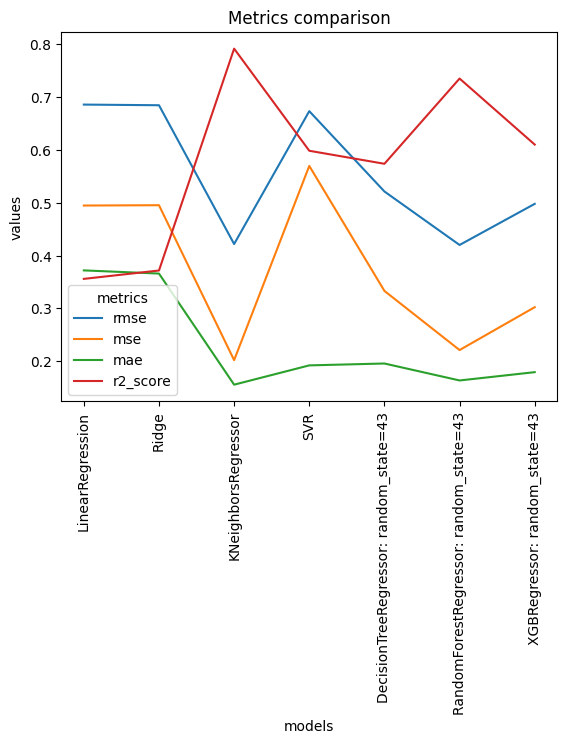

In [16]:
baseline.visualize('rmse', 'mse', 'r2_score', 'mae')


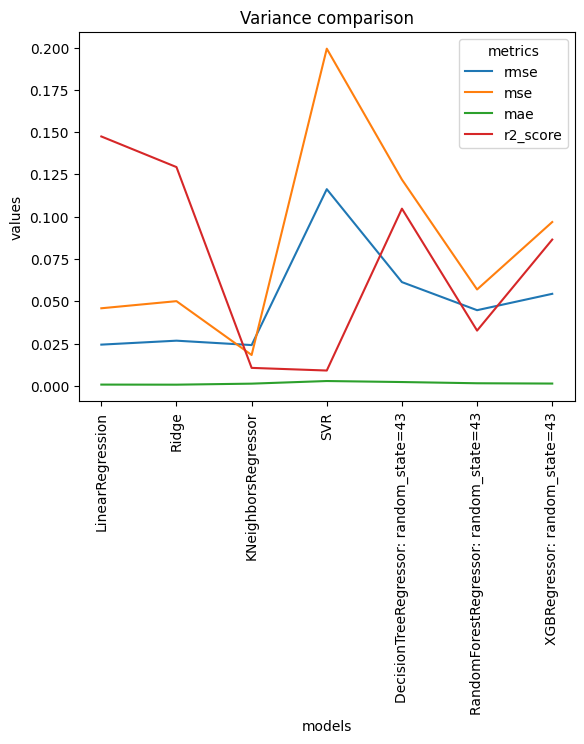

In [17]:
baseline.create_dataframe(chosen_format='variance')
baseline.visualize('rmse', 'mse', 'mae', 'r2_score')


## Optimización k vecinos

- Se buscan los mejores parámetros para la predicción

In [18]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=43)
rmse = make_scorer(calculate_rmse, greater_is_better=False)


### Ronda 1:

In [29]:
#NOT DONE YET
model = KNeighborsRegressor()

params = {
            }

grid = GridSearchCV(
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END n_estimators=100, random_state=43;, score=-0.343 total time=   0.5s
[CV 2/5] END n_estimators=100, random_state=43;, score=-0.378 total time=   0.4s
[CV 3/5] END n_estimators=100, random_state=43;, score=-0.834 total time=   0.4s
[CV 4/5] END n_estimators=100, random_state=43;, score=-0.246 total time=   0.3s
[CV 5/5] END n_estimators=100, random_state=43;, score=-0.301 total time=   0.4s
[CV 1/5] END n_estimators=120, random_state=43;, score=-0.340 total time=   0.4s
[CV 2/5] END n_estimators=120, random_state=43;, score=-0.379 total time=   0.4s
[CV 3/5] END n_estimators=120, random_state=43;, score=-0.822 total time=   0.4s
[CV 4/5] END n_estimators=120, random_state=43;, score=-0.248 total time=   0.4s
[CV 5/5] END n_estimators=120, random_state=43;, score=-0.294 total time=   0.4s
[CV 1/5] END n_estimators=140, random_state=43;, score=-0.339 total time=   0.5s
[CV 2/5] END n_estimators=140, random_state=43